### Ensemble Model (Random Forest Regressor)

In [30]:
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

np.random.seed(1234)

In [31]:
import pandas as pd
df = pd.read_csv("../paddydataset.csv")
X = df.drop('Paddy yield(in Kg)', axis = 1)
y = df['Paddy yield(in Kg)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)


In [32]:
# ----- Create pipeline -----
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=['float64','int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transforming step that standardizes numeric features and one hot encodes categorical features.
# Random Forest methods do not explicitly require standardization/OHE, but instructions ask for a preprocessing pipeline.  
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Put together pipeline with preprocessing column transformer and random forest regressor object
pipe = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestRegressor(random_state=1234))
])

In [33]:
# --- Cross Validation/Hyper parameter tuning ---- 
from sklearn.model_selection import KFold

''' 
Hyperparameters: 
- number of estimators (Random Forest regression trees) used 
- max tree depth 
- minimum number samples required to split a node 
- minimum number of samples required to be in a leaf after a split 
'''
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Use Cross Validation with 5 folds, shuffle=True for reproducibility
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

# implement grid search CV with pipeline, parameter grid, and Kfold cross validation object
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,Pipeline(step...state=1234))])
,param_grid,"{'rf__max_depth': [None, 10, ...], 'rf__min_samples_leaf': [1, 2], 'rf__min_samples_split': [2, 5], 'rf__n_estimators': [100, 200, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [34]:
# --- GridSearchCV model evaluation --- 
# find best parameters, 
print("Best parameters:", grid.best_params_)
print("Best CV R2:", grid.best_score_)
best_model = grid.best_estimator_

Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV R2: 0.991566428663939


In [35]:
# --- Final Evaluation on Test Set --- 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

y_pred = best_model.predict(X_test)

print("Test R2 Score:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))

Test R2 Score: 0.9929889025158515
Test MSE: 568669.7394051808
Test MAE: 539.814877767934


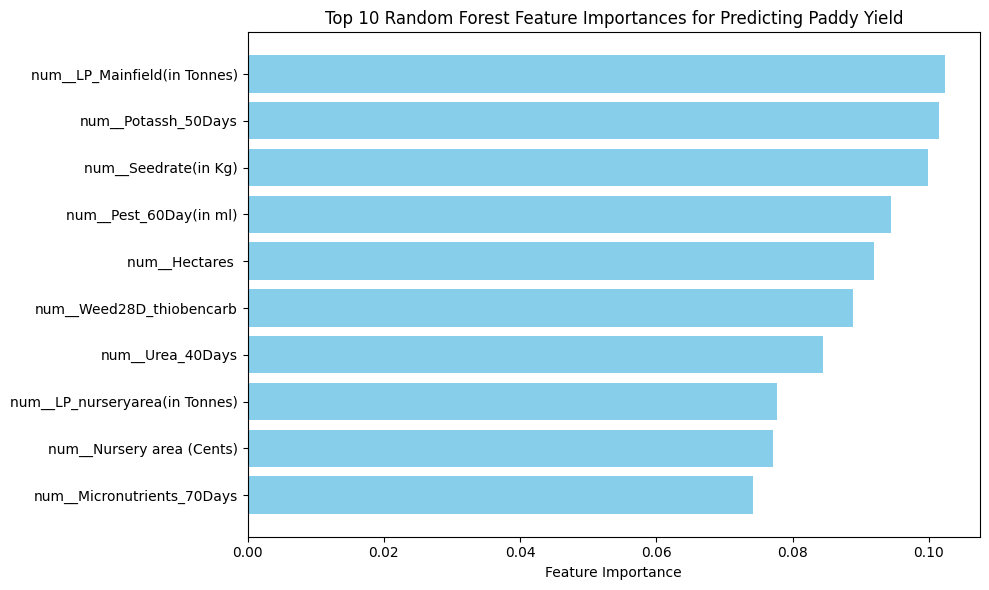

In [43]:
import matplotlib.pyplot as plt

# ---- plot feature importances -----

# extract feature names and importances from pipeline
pre = best_model.named_steps["prep"]
feature_names = pre.get_feature_names_out()
importances = best_model.named_steps["rf"].feature_importances_


# Sort features by importance
indices = np.argsort(importances)[::-1]  # descending order

# Select top 10
top_n = 10
top_indices = indices[:top_n]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]

# plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], color="skyblue")
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Feature Importances for Predicting Paddy Yield")
plt.tight_layout()
plt.show()


### Findings 
- R^2 is very close to 1, indicating almost perfect explained variance. 
- MSE is around 568,669, which is not bad given the scale of the data (high yield numbers)
- MAE is around 540 kilograms, which means that on average, predictions are only off by ~540kg (good). 
- The feature importance chart shows that the strongest predictors of yield are land preparation manure (amount of fertilizer), amount of potassium fertilizer used, and the amount of rice seed sown per unit area. 
